# **Travel Trip dataset - ETL Pipeline**


Structured ETL pipeline to clean, transform, and enrich the plant health dataset from Kaggle.
Includes multi-level stress encoding (binary, zone-based, interaction effects) and visualizations.

## 🌍 Project Objectives – Travel Insights & Cost Analysis

This project explores travel behaviors, preferences, and cost patterns using a rich dataset of traveler demographics, trip details, accommodation, and transport types. The ultimate goal is to generate insights for travel agencies, transport providers, and tourism planners to enhance service design, bundling, and personalization.

This notebook showcases how the dataset can help answer strategic questions and validate hypotheses using both statistical and visual analytics.

## 📌 Key Goals:

- Understand destination preferences by demographic groups.

- Analyze how trip duration, age, and gender affect travel behavior.

- Examine cost variations across accommodation and transportation types.

- Investigate relationships between fuel prices, temperature, and travel cost over time (from external datasets).

- Support product bundling strategies through multi-attribute analysis.

## 🔍 Key Questions

- Which destinations are most popular across age, gender, and nationality?

- How does trip duration vary with age or gender?

- Are accommodation and transport preferences linked to demographics?

- How have transportation costs evolved, and how are they affected by fuel price and climate?

- Which regions or cities show the strongest travel demand?

- Can we categorize travel behaviors into actionable segments for agencies?

## ✅ **Hypotheses**

ID	Hypothesis
H1	Gender significantly influences destination preference
H2	Age group affects trip duration
H3	Age group has a significant correlation with accommodation cost
H4	Age group is associated with destination preference
H5	Age group influences accommodation type
H6	Transportation cost is significantly affected by fuel price
H7	There is a strong association between fuel price and average destination temperature
H8	Fuel prices increased post-2022 war; dropped during 2020–21 COVID years

Note: The pre formulated hypothesis on Nationality vs Destination was excluded due to sparse entries. 


## 📥 **Inputs**

*Dataset Overview*

**Dataset 1:** Traveler Trip Dataset
Includes:

- Traveler demographics (age, gender, nationality)
- Trip duration and dates
- Accommodation and transportation types and costs
- Destination city/country

**Dataset 2:** Global Weather Repository
Used to enrich destination countries with:
- Average temperature (°C)
- Climate zone classification (derived)

**Dataset 3:** U.S. Fuel Price Data (Excel)
Captures monthly fuel price trends from 1990–2025.

- Used to analyze impact of geopolitical events on travel costs

## **Outputs**

- Cleaned and enriched dataset
- Power BI dashboards with multi-page views:
    - Destination preferences
    - Trip duration and demographics
    - Accommodation & transport trends
    - Cost vs fuel price and climate zones
- Markdown-based documentation
- Final .pbix Power BI dashboard file
- Statistical plots (correlation heatmaps, boxplots) from Python
- README for GitHub 

## **Additional Comments**

- City-to-country mapping was resolved using a custom lookup table
- Transport and accommodation costs were binned for better interpretability
- Rare category encoding and ordinal encoding were used to simplify analysis
- Fuel prices were averaged and mapped against time and country climate
- Advanced visuals (heatmaps, scatter matrices) are created in Python and imported into Power BI

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy


### Travel Data set upload

In [3]:
import os

current_dir = os.getcwd()
current_dir

os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")
current_dir = os.getcwd()
current_dir

You set a new current directory


'c:\\Users\\baner\\OneDrive\\Documenti\\data_analytics_AI\\Travel_analysis_Hackathon\\travel_trends'

In [4]:
# Create environment
# source/Scripts/activate
# pip install -r requirements.txt
# pip freeze > requirements.txt

# Set paths
raw_path = "data/raw/Travel details dataset.csv"
processed_path = "data/processed/Travel details dataset_cleaned.csv"

# Ensure directories exist
os.makedirs(os.path.dirname(raw_path), exist_ok=True)
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Load dataset
df = pd.read_csv(raw_path)
df.head()

,Trip ID,Destination,Start date,End date,Duration (days),Traveler name,Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost
0,1,"London, UK",5/1/2023,5/8/2023,7.0,John Smith,35.0,Male,American,Hotel,1200,Flight,600
1,2,"Phuket, Thailand",6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Resort,800,Flight,500
2,3,"Bali, Indonesia",7/1/2023,7/8/2023,7.0,David Lee,45.0,Male,Korean,Villa,1000,Flight,700
3,4,"New York, USA",8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Hotel,2000,Flight,1000
4,5,"Tokyo, Japan",9/10/2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Airbnb,700,Train,200


### This includes the number of non-null entries, data types, and memory usage for each column

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Trip ID               139 non-null    int64  
 1   Destination           137 non-null    object 
 2   Start date            137 non-null    object 
 3   End date              137 non-null    object 
 4   Duration (days)       137 non-null    float64
 5   Traveler name         137 non-null    object 
 6   Traveler age          137 non-null    float64
 7   Traveler gender       137 non-null    object 
 8   Traveler nationality  137 non-null    object 
 9   Accommodation type    137 non-null    object 
 10  Accommodation cost    137 non-null    object 
 11  Transportation type   136 non-null    object 
 12  Transportation cost   136 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 14.2+ KB


### Drop Trip ID column

In [6]:
df.drop(columns=["Trip ID", "Traveler name"], inplace=True)

### Drop all rows with missing values

In [7]:
df.dropna(inplace=True)

### Convert the 'Start Time' and 'End Time' columns to datetime format

In [8]:
df["Start date"] = pd.to_datetime(df["Start date"])
df["End date"] = pd.to_datetime(df["End date"])
df.head()
df.shape

(136, 11)

### Create three new columns: 'Month', 'Month Name', 'Year'

In [9]:
df["Month"] = df["Start date"].dt.month
df["Month_name"] = df["Start date"].dt.month_name()
df["Year"] = df["Start date"].dt.year

### Replace characters with empty string in order to convert Accomodation cost and Transport cost to numeric

In [10]:
df["Accommodation cost"] = df["Accommodation cost"].replace(
    {" USD": "", ",": ""}, regex=True
)
df["Transportation cost"] = df["Transportation cost"].replace(
    {" USD": "", ",": ""}, regex=True
)
df.head()

,Destination,Start date,End date,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Month,Month_name,Year
0,"London, UK",2023-05-01,2023-05-08,7.0,35.0,Male,American,Hotel,1200,Flight,600,5,May,2023
1,"Phuket, Thailand",2023-06-15,2023-06-20,5.0,28.0,Female,Canadian,Resort,800,Flight,500,6,June,2023
2,"Bali, Indonesia",2023-07-01,2023-07-08,7.0,45.0,Male,Korean,Villa,1000,Flight,700,7,July,2023
3,"New York, USA",2023-08-15,2023-08-29,14.0,29.0,Female,British,Hotel,2000,Flight,1000,8,August,2023
4,"Tokyo, Japan",2023-09-10,2023-09-17,7.0,26.0,Female,Vietnamese,Airbnb,700,Train,200,9,September,2023


### Replace $ sign with empty string in order to convert Accomodation cost and Transport cost to numeric

In [11]:
df["Accommodation cost"] = (
    df["Accommodation cost"].str.replace("$", "", regex=False).astype(int)
)
df["Transportation cost"] = (
    df["Transportation cost"].str.replace("$", "", regex=False).astype(int)
)
df.head()

,Destination,Start date,End date,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Month,Month_name,Year
0,"London, UK",2023-05-01,2023-05-08,7.0,35.0,Male,American,Hotel,1200,Flight,600,5,May,2023
1,"Phuket, Thailand",2023-06-15,2023-06-20,5.0,28.0,Female,Canadian,Resort,800,Flight,500,6,June,2023
2,"Bali, Indonesia",2023-07-01,2023-07-08,7.0,45.0,Male,Korean,Villa,1000,Flight,700,7,July,2023
3,"New York, USA",2023-08-15,2023-08-29,14.0,29.0,Female,British,Hotel,2000,Flight,1000,8,August,2023
4,"Tokyo, Japan",2023-09-10,2023-09-17,7.0,26.0,Female,Vietnamese,Airbnb,700,Train,200,9,September,2023


### Convert Duration (days) and Traverler age columns to 'int' data type

In [12]:
df["Duration (days)"] = df["Duration (days)"].astype(int)
df["Traveler age"] = df["Traveler age"].astype(int)

### Create new Dest_Country column from Destination column for future analysis

In [13]:
Dest_Country = []
for i in df["Destination"]:
    if i == "London, UK":
        Dest_Country.append("UK")
    elif i == "Phuket, Thailand":
        Dest_Country.append("Thailand")
    elif i == "Bangkok, Thai":
        Dest_Country.append("Thailand")
    elif i == "Bali, Indonesia":
        Dest_Country.append("Indonesia")
    elif i == "New York, USA":
        Dest_Country.append("USA")
    elif i == "Tokyo, Japan":
        Dest_Country.append("Japan")
    elif i == "Paris, France":
        Dest_Country.append("France")
    elif i == "Sydney, Australia":
        Dest_Country.append("Australia")
    elif i == "Rio de Janeiro, Brazil":
        Dest_Country.append("Brazil")
    elif i == "Amsterdam, Netherlands":
        Dest_Country.append("Netherlands")
    elif i == "Amsterdam":
        Dest_Country.append("Netherlands")
    elif i == "Dubai, United Arab Emirates":
        Dest_Country.append("UAE")
    elif i == "Cancun, Mexico":
        Dest_Country.append("Mexico")
    elif i == "Honolulu, Hawaii":
        Dest_Country.append("USA")
    elif i == "Barcelona, Spain":
        Dest_Country.append("Spain")
    elif i == "Berlin, Germany":
        Dest_Country.append("Germany")
    elif i == "Marrakech, Morocco":
        Dest_Country.append("Morocco")
    elif i == "Paris":
        Dest_Country.append("France")
    elif i == "Bali":
        Dest_Country.append("Indonesia")
    elif i == "Tokyo":
        Dest_Country.append("Japan")
    elif i == "London":
        Dest_Country.append("UK")
    elif i == "New York":
        Dest_Country.append("USA")
    elif i == "Sydney":
        Dest_Country.append("Australia")
    elif i == "Rome":
        Dest_Country.append("Italy")
    elif i == "Bangkok":
        Dest_Country.append("Thailand")
    elif i == "Hawaii":
        Dest_Country.append("USA")
    elif i == "Barcelona":
        Dest_Country.append("Spain")
    elif i == "New York City, USA":
        Dest_Country.append("USA")
    elif i == "Los Angeles, USA":
        Dest_Country.append("USA")
    elif i == "Vancouver, Canada":
        Dest_Country.append("Canada")
    elif i == "Sydney, AUS":
        Dest_Country.append("Australia")
    elif i == "Sydney, Aus":
        Dest_Country.append("Australia")
    elif i == "Seoul, South Korea":
        Dest_Country.append("South Korea")
    elif i == "Cape Town":
        Dest_Country.append("South Africa")
    elif i == "Cape Town, SA":
        Dest_Country.append("South Africa")
    elif i == "Cancun, Mexico":
        Dest_Country.append("Mexico")
    elif i == "Athens, Greece":
        Dest_Country.append("Greece")
    elif i == "Rome, Italy":
        Dest_Country.append("Italy")
    elif i == "Auckland, New Zealand":
        Dest_Country.append("New Zealand")
    elif i == "Rio de Janeiro":
        Dest_Country.append("Brazil")
    elif i == "Dubai":
        Dest_Country.append("UAE")
    elif i == "Bangkok, Thailand":
        Dest_Country.append("Thailand")
    elif i == "Seoul":
        Dest_Country.append("South Korea")
    elif i == "Phuket, Thai":
        Dest_Country.append("Thailand")
    elif i == "Phuket":
        Dest_Country.append("Thailand")
    elif i == "Santorini":
        Dest_Country.append("Greece")
    elif i == "Phnom Penh":
        Dest_Country.append("Cambodia")
    elif i == "Cape Town, South Africa":
        Dest_Country.append("South Africa")
    elif i == "United Kingdom":
        Dest_Country.append("UK")
    elif i == "Edinburgh, Scotland":
        Dest_Country.append("UK")
    else:
        Dest_Country.append(i)
df["Dest_Country"] = Dest_Country

In [14]:
df.shape

(136, 15)

To standardize and extract the **destination country** from the mixed-format `Destination` column (which contains both cities and countries), we created a **lookup dictionary**. This maps common destinations to their respective countries, handling both full "City, Country" formats and standalone city names.

This approach:
- Avoids repetitive conditional logic
- Simplifies updates via a central mapping dictionary
- Ensures fallback to original values for unmapped entries

```python
df['Dest_Country'] = df['Destination'].map(destination_country_map).fillna(df['Destination'])

In [15]:
# Define mapping dictionary
destination_country_map = {
    "London, UK": "UK",
    "Phuket, Thailand": "Thailand",
    "Bangkok, Thai": "Thailand",
    "Bali, Indonesia": "Indonesia",
    "New York, USA": "USA",
    "Tokyo, Japan": "Japan",
    "Paris, France": "France",
    "Sydney, Australia": "Australia",
    "Rio de Janeiro, Brazil": "Brazil",
    "Amsterdam, Netherlands": "Netherlands",
    "Amsterdam": "Netherlands",
    "Dubai, United Arab Emirates": "UAE",
    "Cancun, Mexico": "Mexico",
    "Honolulu, Hawaii": "USA",
    "Barcelona, Spain": "Spain",
    "Berlin, Germany": "Germany",
    "Marrakech, Morocco": "Morocco",
    "Paris": "France",
    "Bali": "Indonesia",
    "Tokyo": "Japan",
    "London": "UK",
    "New York": "USA",
    "Sydney": "Australia",
    "Rome": "Italy",
    "Bangkok": "Thailand",
    "Hawaii": "USA",
    "Barcelona": "Spain",
    "New York City, USA": "USA",
    "Los Angeles, USA": "USA",
    "Vancouver, Canada": "Canada",
    "Sydney, AUS": "Australia",
    "Sydney, Aus": "Australia",
    "Seoul, South Korea": "South Korea",
    "Cape Town": "South Africa",
    "Cape Town, SA": "South Africa",
    "Athens, Greece": "Greece",
    "Rome, Italy": "Italy",
    "Auckland, New Zealand": "New Zealand",
    "Rio de Janeiro": "Brazil",
    "Dubai": "UAE",
    "Bangkok, Thailand": "Thailand",
    "Seoul": "South Korea",
    "Phuket, Thai": "Thailand",
    "Phuket": "Thailand",
    "Santorini": "Greece",
    "Phnom Penh": "Cambodia",
    "Cape Town, South Africa": "South Africa",
    "United Kingdom": "UK",
    "Edinburgh, Scotland": "UK",
}

# Apply mapping
df["Dest_Country"] = df["Destination"].apply(
    lambda x: destination_country_map.get(x.strip(), x.strip())
)


### Create Age_Group column from Traveler Age column for future analysis

In [16]:
Age_Group = []
for i in df["Traveler age"]:
    if i < 29:
        Age_Group.append("Youth")
    elif i < 39:
        Age_Group.append("Young Adult")
    elif i < 49:
        Age_Group.append("Mid Adult")
    elif i < 59:
        Age_Group.append("Mature Adult")
    else:
        Age_Group.append("Senior")
df["Age_Group"] = Age_Group

In [17]:
df.shape

(136, 16)

### Upload fuel_price data set which was partially cleaned separately

In [18]:
df1 = pd.read_csv("data/processed/fuel_price.csv")
df1.head()

,Date,Fuel Price($/gal),Year,Month
0,2021-01-15,2.420,2021,1
1,2021-02-15,2.587,2021,2
2,2021-03-15,2.898,2021,3
3,2021-04-15,2.948,2021,4
4,2021-05-15,3.076,2021,5


### Convert Date column to datetime format
### Create two new columns: 'Pricing_Month_Name' and 'Pricing_Year'
### Drop Date, Year and Month columns

In [19]:
df1["Date"] = pd.to_datetime(df1["Date"])
df1["Pricing_Month_Name"] = df1["Date"].dt.month_name()
df1["Pricing_Year"] = df1["Date"].dt.year
df1.drop(columns=["Date", "Year", "Month"], inplace=True)
df1.head()

,Fuel Price($/gal),Pricing_Month_Name,Pricing_Year
0,2.420,January,2021
1,2.587,February,2021
2,2.898,March,2021
3,2.948,April,2021
4,3.076,May,2021


### Merge fuel_price with Travel data set to travel_da dataframe for the ease of data analysis

In [20]:
travel_da = pd.merge(
    df,
    df1,
    how="inner",
    left_on=["Year", "Month_name"],
    right_on=["Pricing_Year", "Pricing_Month_Name"],
)
travel_da.head()

,Destination,Start date,End date,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Month,Month_name,Year,Dest_Country,Age_Group,Fuel Price($/gal),Pricing_Month_Name,Pricing_Year
0,"London, UK",2023-05-01,2023-05-08,7,35,Male,American,Hotel,1200,Flight,600,5,May,2023,UK,Young Adult,3.666,May,2023
1,"Bangkok, Thailand",2023-05-01,2023-05-07,6,29,Female,Indian,Airbnb,500,Bus,50,5,May,2023,Thailand,Young Adult,3.666,May,2023
2,New York,2023-05-08,2023-05-14,6,50,Male,China,Airbnb,800,Car rental,300,5,May,2023,USA,Mature Adult,3.666,May,2023
3,"Paris, France",2023-05-01,2023-05-07,6,35,Male,American,Hotel,5000,Airplane,2500,5,May,2023,France,Young Adult,3.666,May,2023
4,"Tokyo, Japan",2023-05-15,2023-05-22,7,28,Female,British,Airbnb,7000,Train,1500,5,May,2023,Japan,Youth,3.666,May,2023


In [21]:
travel_da.shape

(135, 19)

### Remove the 'Pricing_Month_Name' and 'Pricing_Year' columns from the merged dataframe as they are redundant

In [22]:
travel_da.drop(columns=["Pricing_Month_Name", "Pricing_Year"], inplace=True)
travel_da.head()

,Destination,Start date,End date,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Month,Month_name,Year,Dest_Country,Age_Group,Fuel Price($/gal)
0,"London, UK",2023-05-01,2023-05-08,7,35,Male,American,Hotel,1200,Flight,600,5,May,2023,UK,Young Adult,3.666
1,"Bangkok, Thailand",2023-05-01,2023-05-07,6,29,Female,Indian,Airbnb,500,Bus,50,5,May,2023,Thailand,Young Adult,3.666
2,New York,2023-05-08,2023-05-14,6,50,Male,China,Airbnb,800,Car rental,300,5,May,2023,USA,Mature Adult,3.666
3,"Paris, France",2023-05-01,2023-05-07,6,35,Male,American,Hotel,5000,Airplane,2500,5,May,2023,France,Young Adult,3.666
4,"Tokyo, Japan",2023-05-15,2023-05-22,7,28,Female,British,Airbnb,7000,Train,1500,5,May,2023,Japan,Youth,3.666


In [23]:
travel_da.shape

(135, 17)

### Re-arrange the columns in the merged dataframe

In [24]:
travel_da = travel_da[
    [
        "Destination",
        "Dest_Country",
        "Start date",
        "End date",
        "Month",
        "Month_name",
        "Year",
        "Duration (days)",
        "Traveler age",
        "Age_Group",
        "Traveler gender",
        "Traveler nationality",
        "Accommodation type",
        "Accommodation cost",
        "Transportation type",
        "Transportation cost",
        "Fuel Price($/gal)",
    ]
]

In [25]:
travel_da.shape

(135, 17)

### Upload Temperature data set which was partially cleaned separately

In [26]:
df2 = pd.read_csv("data/processed/Temperature Data.csv")
df2.head()

,country,temperature_celsius,W_Date,Temp_month,Temp_year
0,Afghanistan,26.6,2024-05-16,5,2024
1,Albania,19.0,2024-05-16,5,2024
2,Algeria,23.0,2024-05-16,5,2024
3,Andorra,6.3,2024-05-16,5,2024
4,Angola,26.0,2024-05-16,5,2024


### Rename and adjust country column data according to the travel data set

To ensure consistency in naming conventions across datasets, this utility function maps long or verbose country names to standardized abbreviations. This is particularly useful for merging/joining datasets or for clean display in dashboards.

In [27]:
def country_mapping(country):
    """
    Maps country names to standardized abbreviations or formats.

    Parameters:
    country (str): The name of the country to be mapped.

    Returns:
    str: The standardized country name or abbreviation. If the country is not in the predefined mapping,
         the original country name is returned.
    """
    if country == "United States of America":
        return "USA"
    elif country == "United Kingdom":
        return "UK"
    elif country == "South Korea":
        return "South Korea"
    elif country == "United Arab Emirates":
        return "UAE"
    else:
        return country


df2["country"] = df2["country"].apply(country_mapping)

### Matching contry names in the temperature data set with the travel data set and save it as SET

In [28]:
matching = set(travel_da["Dest_Country"]) & set(df2["country"])
matching

{'Australia',
 'Brazil',
 'Cambodia',
 'Canada',
 'Egypt',
 'France',
 'Germany',
 'Greece',
 'Indonesia',
 'Italy',
 'Japan',
 'Mexico',
 'Morocco',
 'Netherlands',
 'New Zealand',
 'South Africa',
 'South Korea',
 'Spain',
 'Thailand',
 'UAE',
 'UK',
 'USA'}

In [29]:
travel_da.shape

(135, 17)

### Keep country names in the temperature data set which are in 'matching' SET

In [30]:
df2["Country"] = df2["country"].apply(lambda x: x if x in matching else None)

### Remove redundant 'Country' column from the temperature data set

In [31]:
df2.dropna(subset=["Country"], inplace=True)
df2

,country,temperature_celsius,W_Date,Temp_month,Temp_year,Country
8,Australia,9.0,2024-05-16,5,2024,Australia
23,Brazil,23.1,2024-05-16,5,2024,Brazil
30,Cambodia,38.0,2024-05-16,5,2024,Cambodia
32,Canada,12.0,2024-05-16,5,2024,Canada
51,Egypt,27.0,2024-05-16,5,2024,Egypt
...,...,...,...,...,...,...
68766,Spain,13.1,2025-05-05,5,2025,Spain
68775,Thailand,29.1,2025-05-05,5,2025,Thailand
68786,UAE,43.1,2025-05-05,5,2025,UAE
68787,UK,10.0,2025-05-05,5,2025,UK


### Get average temperature of a country from the data set
### Rename 'temperature_celsius' column to 'Avg_Temperature_Celsius'

In [32]:
weather_data = pd.DataFrame(
    df2.groupby("Country")["temperature_celsius"].mean()
).reset_index()
weather_data.rename(columns={"temperature_celsius": "Avg_Temperature"}, inplace=True)

### Check the output of the weather_data dataframe

To enable climate-based analysis and segmentation, the `climate_mapping()` function classifies average country temperatures into meaningful climate bands.


In [33]:
def climate_mapping(temp):
    if temp < 10:
        return "Very Cold"
    elif temp < 16:
        return "Cool"
    elif temp < 22:
        return "Mild"
    elif temp < 28:
        return "Warm"
    else:
        return "Hot"


weather_data["Climate"] = weather_data["Avg_Temperature"].apply(climate_mapping)

In [34]:
weather_data.head()

,Country,Avg_Temperature,Climate
0,Australia,12.971751,Cool
1,Brazil,25.356286,Warm
2,Cambodia,31.021246,Hot
3,Canada,5.389744,Very Cold
4,Egypt,27.292635,Warm


### Now, merge the weather_data with travel_data dataframe
### Remove the 'Country' column from the merged dataframe as it is redundant

In [35]:
travel_da = pd.merge(
    travel_da, weather_data, how="inner", left_on=["Dest_Country"], right_on=["Country"]
)
travel_da.drop(columns=["Country"], inplace=True)
travel_da.head()

,Destination,Dest_Country,Start date,End date,Month,Month_name,Year,Duration (days),Traveler age,Age_Group,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Fuel Price($/gal),Avg_Temperature,Climate
0,"London, UK",UK,2023-05-01,2023-05-08,5,May,2023,7,35,Young Adult,Male,American,Hotel,1200,Flight,600,3.666,12.891477,Cool
1,London,UK,2023-07-22,2023-07-28,7,July,2023,6,35,Young Adult,Female,British,Hotel,1200,Train,150,3.712,12.891477,Cool
2,"London, UK",UK,2024-03-15,2024-03-23,3,March,2024,8,35,Young Adult,Male,British,Hotel,1000,Train,200,3.542,12.891477,Cool
3,"Edinburgh, Scotland",UK,2024-09-05,2024-09-12,9,September,2024,7,32,Young Adult,Male,Scottish,Hotel,900,Train,150,3.338,12.891477,Cool
4,London,UK,2022-06-10,2022-06-15,6,June,2022,5,38,Young Adult,Female,United Kingdom,Hotel,900,Train,150,5.032,12.891477,Cool


In [36]:
travel_da.shape

(135, 19)

### 🏨 Accommodation Cost Categorization

To better analyze spending behavior across traveler segments, the `accommodation_cost_mapping()` function maps raw accommodation cost values to qualitative categories.

Finding the min. and max. values of accomodation and transportation cost

In [37]:
travel_da["Accommodation cost"].min(), travel_da["Accommodation cost"].max()
travel_da["Transportation cost"].min(), travel_da["Transportation cost"].max()

(20, 3000)

In [38]:
def accommodation_cost_mapping(cost):
    if cost < 500:
        return "Very cheap"
    elif cost < 1000:
        return "Cheap"
    elif cost < 1500:
        return "Low"
    elif cost < 2000:
        return "Medium"
    elif cost < 2500:
        return "Medium high"
    elif cost < 3000:
        return "High"
    elif cost < 3500:
        return "Very high"
    else:
        return "Very expensive"


travel_da["Accommodation cost category"] = travel_da["Accommodation cost"].apply(
    accommodation_cost_mapping
)

### Transportation Cost Categorization

To better understand transportation spending behavior, we binned the `Transportation cost` values into categorical labels using a custom function. This allows for clearer visual comparison of travel budgets and pricing strategies across demographic groups and destinations.

Categories used:
- Very cheap (< $100)
- Cheap ($100–$499)
- Low ($500–$999)
- Medium ($1000–$1499)
- Medium high ($1500–$1999)
- High ($2000–$2499)
- Very high ($2500–$2699)
- Very expensive (≥ $2700)

In [39]:
def transportation_cost_mapping(cost):
    if cost < 100:
        return "Very cheap"
    elif cost < 500:
        return "Cheap"
    elif cost < 1000:
        return "Low"
    elif cost < 1500:
        return "Medium"
    elif cost < 2000:
        return "Mediam high"
    elif cost < 2500:
        return "High"
    elif cost < 2700:
        return "Very high"
    else:
        return "Very expensive"


travel_da["Transportation cost category"] = travel_da["Transportation cost"].apply(
    transportation_cost_mapping
)

### Check the status of the final merged dataframe

In [40]:
travel_da.describe(include="all")

,Destination,Dest_Country,Start date,End date,Month,Month_name,Year,Duration (days),Traveler age,Age_Group,...,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Fuel Price($/gal),Avg_Temperature,Climate,Accommodation cost category,Transportation cost category
count,135,135,135,135,135.000000,135,135.000000,135.000000,135.000000,135,...,135,135,135.000000,135,135.000000,135.000000,135.000000,135,135,135
unique,59,22,NaN,NaN,NaN,12,NaN,NaN,NaN,5,...,41,8,NaN,9,NaN,NaN,NaN,5,8,8
top,"Paris, France",France,NaN,NaN,NaN,September,NaN,NaN,NaN,Young Adult,...,American,Hotel,NaN,Plane,NaN,NaN,NaN,Cool,Cheap,Low
freq,7,15,NaN,NaN,NaN,17,NaN,NaN,NaN,63,...,23,59,NaN,56,NaN,NaN,NaN,48,53,55
mean,NaN,NaN,2023-04-25 06:24:00,2023-05-02 19:12:00,6.688889,NaN,2022.814815,7.607407,33.088889,NaN,...,NaN,NaN,1249.481481,NaN,642.555556,3.793822,18.313095,NaN,NaN,NaN
min,NaN,NaN,2021-06-15 00:00:00,2021-06-20 00:00:00,1.000000,NaN,2021.000000,5.000000,20.000000,NaN,...,NaN,NaN,150.000000,NaN,20.000000,3.157000,5.389744,NaN,NaN,NaN
25%,NaN,NaN,2022-08-28 12:00:00,2022-09-06 00:00:00,5.000000,NaN,2022.000000,7.000000,28.000000,NaN,...,NaN,NaN,600.000000,NaN,200.000000,3.496000,12.971751,NaN,NaN,NaN
50%,NaN,NaN,2023-06-07 00:00:00,2023-06-14 00:00:00,7.000000,NaN,2023.000000,7.000000,31.000000,NaN,...,NaN,NaN,900.000000,NaN,500.000000,3.712000,17.404533,NaN,NaN,NaN
75%,NaN,NaN,2023-11-16 00:00:00,2023-11-22 12:00:00,9.000000,NaN,2023.000000,8.000000,37.500000,NaN,...,NaN,NaN,1200.000000,NaN,800.000000,3.954000,24.485487,NaN,NaN,NaN
max,NaN,NaN,2025-02-14 00:00:00,2025-02-20 00:00:00,12.000000,NaN,2025.000000,14.000000,60.000000,NaN,...,NaN,NaN,8000.000000,NaN,3000.000000,5.032000,32.225141,NaN,NaN,NaN


**Cleaned-Up Summary Statistics**

To improve the readability and usefulness of our dataset summary, we split the describe() output by data type instead of using include='all', which often results in NaN values.

In [41]:
# Only numeric
travel_da.describe()

,Start date,End date,Month,Year,Duration (days),Traveler age,Accommodation cost,Transportation cost,Fuel Price($/gal),Avg_Temperature
count,135,135,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,2023-04-25 06:24:00,2023-05-02 19:12:00,6.688889,2022.814815,7.607407,33.088889,1249.481481,642.555556,3.793822,18.313095
min,2021-06-15 00:00:00,2021-06-20 00:00:00,1.000000,2021.000000,5.000000,20.000000,150.000000,20.000000,3.157000,5.389744
25%,2022-08-28 12:00:00,2022-09-06 00:00:00,5.000000,2022.000000,7.000000,28.000000,600.000000,200.000000,3.496000,12.971751
50%,2023-06-07 00:00:00,2023-06-14 00:00:00,7.000000,2023.000000,7.000000,31.000000,900.000000,500.000000,3.712000,17.404533
75%,2023-11-16 00:00:00,2023-11-22 12:00:00,9.000000,2023.000000,8.000000,37.500000,1200.000000,800.000000,3.954000,24.485487
max,2025-02-14 00:00:00,2025-02-20 00:00:00,12.000000,2025.000000,14.000000,60.000000,8000.000000,3000.000000,5.032000,32.225141
std,NaN,NaN,3.052933,0.856801,1.611972,7.158615,1342.794101,585.845755,0.448528,7.227302


In [42]:
# Only object (categorical)
travel_da.describe(include=["object"])

,Destination,Dest_Country,Month_name,Age_Group,Traveler gender,Traveler nationality,Accommodation type,Transportation type,Climate,Accommodation cost category,Transportation cost category
count,135,135,135,135,135,135,135,135,135,135,135
unique,59,22,12,5,2,41,8,9,5,8,8
top,"Paris, France",France,September,Young Adult,Female,American,Hotel,Plane,Cool,Cheap,Low
freq,7,15,17,63,69,23,59,56,48,53,55


In [43]:
# Only datetime
travel_da.describe(include=["datetime"])

,Start date,End date
count,135,135
mean,2023-04-25 06:24:00,2023-05-02 19:12:00
min,2021-06-15 00:00:00,2021-06-20 00:00:00
25%,2022-08-28 12:00:00,2022-09-06 00:00:00
50%,2023-06-07 00:00:00,2023-06-14 00:00:00
75%,2023-11-16 00:00:00,2023-11-22 12:00:00
max,2025-02-14 00:00:00,2025-02-20 00:00:00


In [44]:
# Summary per column type
for col in travel_da.columns:
    print(f"\n--- {col} ({travel_da[col].dtype}) ---")
    print(travel_da[col].describe())


--- Destination (object) ---
count               135
unique               59
top       Paris, France
freq                  7
Name: Destination, dtype: object

--- Dest_Country (object) ---
count        135
unique        22
top       France
freq          15
Name: Dest_Country, dtype: object

--- Start date (datetime64[ns]) ---
count                    135
mean     2023-04-25 06:24:00
min      2021-06-15 00:00:00
25%      2022-08-28 12:00:00
50%      2023-06-07 00:00:00
75%      2023-11-16 00:00:00
max      2025-02-14 00:00:00
Name: Start date, dtype: object

--- End date (datetime64[ns]) ---
count                    135
mean     2023-05-02 19:12:00
min      2021-06-20 00:00:00
25%      2022-09-06 00:00:00
50%      2023-06-14 00:00:00
75%      2023-11-22 12:00:00
max      2025-02-20 00:00:00
Name: End date, dtype: object

--- Month (int32) ---
count    135.000000
mean       6.688889
std        3.052933
min        1.000000
25%        5.000000
50%        7.000000
75%        9.000000
max  

In [45]:
travel_da.shape

(135, 21)

### Mapping Traveler Nationalities

Standardize nationality values for better grouping and visual clarity.


In [46]:
def nationality_mapping(country):
    if country == "United Kingdom":
        return "British"
    elif country == "UK":
        return "British"
    elif country == "Scottish":
        return "British"
    elif country == "United Arab Emirates":
        return "Emirati"
    elif country == "China":
        return "Chinese"
    elif country == "Hong Kong":
        return "Chinese"
    elif country == "Spanish":
        return "Spanish"
    elif country == "USA":
        return "American"
    elif country == "Singapore":
        return "Singaporean"
    elif country == "Korean":
        return "South Korean"
    elif country == "Taiwan":
        return "Taiwanese"
    elif country == "Brazil":
        return "Brazilian"
    elif country == "Greece":
        return "Greek"
    elif country == "Cambodia":
        return "Cambodian"
    elif country == "Japan":
        return "Japanese"
    elif country == "Germany":
        return "German"
    elif country == "Italy":
        return "Italian"
    else:
        return country


travel_da["Traveler nationality"] = travel_da["Traveler nationality"].apply(
    nationality_mapping
)
travel_da.head()

,Destination,Dest_Country,Start date,End date,Month,Month_name,Year,Duration (days),Traveler age,Age_Group,...,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Fuel Price($/gal),Avg_Temperature,Climate,Accommodation cost category,Transportation cost category
0,"London, UK",UK,2023-05-01,2023-05-08,5,May,2023,7,35,Young Adult,...,American,Hotel,1200,Flight,600,3.666,12.891477,Cool,Low,Low
1,London,UK,2023-07-22,2023-07-28,7,July,2023,6,35,Young Adult,...,British,Hotel,1200,Train,150,3.712,12.891477,Cool,Low,Cheap
2,"London, UK",UK,2024-03-15,2024-03-23,3,March,2024,8,35,Young Adult,...,British,Hotel,1000,Train,200,3.542,12.891477,Cool,Low,Cheap
3,"Edinburgh, Scotland",UK,2024-09-05,2024-09-12,9,September,2024,7,32,Young Adult,...,British,Hotel,900,Train,150,3.338,12.891477,Cool,Cheap,Cheap
4,London,UK,2022-06-10,2022-06-15,6,June,2022,5,38,Young Adult,...,British,Hotel,900,Train,150,5.032,12.891477,Cool,Cheap,Cheap


In [47]:
travel_da.shape

(135, 21)

To standardize traveler nationality values, we use a dictionary-based mapping. The following line applies the transformation safely:

```python
travel_da['Traveler nationality'] = travel_da['Traveler nationality'].apply(lambda x: nationality_dict.get(x, x))
```

Explanation:

x: Each original value in the 'Traveler nationality' column.

nationality_dict.get(x, x): Looks up x in the mapping dictionary.

If found, replaces x with the mapped value.

If not found, returns x unchanged (prevents errors).

In [48]:
# Define mapping dictionary
nationality_dict = {
    "United Kingdom": "British",
    "UK": "British",
    "Scottish": "British",
    "United Arab Emirates": "Emirati",
    "China": "Chinese",
    "Hong Kong": "Chinese",
    "Spanish": "Spanish",
    "USA": "American",
    "Singapore": "Singaporean",
    "Korean": "South Korean",
    "Taiwan": "Taiwanese",
    "Brazil": "Brazilian",
    "Greece": "Greek",
    "Cambodia": "Cambodian",
    "Japan": "Japanese",
    "Germany": "German",
    "Italy": "Italian",
}

# Apply mapping function
travel_da["Traveler nationality"] = travel_da["Traveler nationality"].apply(
    lambda x: nationality_dict.get(x, x)  # Default to original if not in mapping
)


In [49]:
travel_da.shape

(135, 21)

In [50]:
travel_da.to_csv("data/processed/Travel details dataset_cleaned.csv", index=False)

---

## Feature Engineering

🧠 Feature Encoding Strategy
In this project, we opted for custom pandas-based encoders instead of using external libraries like category_encoders. This decision was made based on the following reasons:

✅ Compatibility: Issues with RareLabelEncoder from category_encoders due to Python 3.12's deprecation of internal modules (ImpImporter) made installation difficult.

✅ Simplicity: For our use case, encoding with pandas provides the required functionality with full control and readability.

✅ Hackathon Constraint: Avoiding additional dependencies helps streamline the setup for teammates and reviewers.

### 🧹 Rare Label Encoding (Handling Categorical Noise)

In real-world datasets, some categories within categorical variables appear very infrequently. These rare categories may:

- Add noise to the model  
- Inflate dimensionality during one-hot or ordinal encoding  
- Reduce generalization in downstream analysis or machine learning  

To handle this, we apply **rare label encoding**, where we group all low-frequency categories into a single category called `"Rare"`.

#### 🧠 Logic
We define a frequency threshold (e.g., 5%).  
If a category appears in less than that proportion of the total rows, it's labeled as `"Rare"`.

#### 🔧 Applied Columns & Thresholds
- `Dest_Country` → Rare if < **5%**
- `Transportation type` → Rare if < **7%**
- `Accommodation type` → Rare if < **10%**t_Country:`
- **tol=0.05**: This means any category that appears in less than 5% of the samples will be considered "rare".
- **n_categories=5**: This ensures that at least 5 most frequent categories will be retained, even if they appear in less than 5% of the data. All others will be labeled as 'Rare'

`For Transport_type:`
- **tol=0.07**: This means any category that appears in less than 7% of the samples will be considered "rare".
- **n_categories=5**: This ensures that at least 5 most frequent categories will be retained, even if they appear in less than 7% of the data. All others will be labeled as 'Rare'

`For Accomodation type:`
- **tol=0.1**: This means any category that appears in less than 10% of the samples will be considered "rare".
- **n_categories=5**: This ensures that at least 5 most frequent categories will be retained, even if they appear in less than 10% of the data. All others will be labeled as 'Rare'


This was done using a custom pandas-based function for compatibility and simplicity:

In [51]:
def rare_label_encoder(df, column, threshold=0.05):
    """
    Replaces rare categories in a column with the label 'Rare'.

    Parameters:
        df (pd.DataFrame): The dataframe containing the column.
        column (str): The column to encode.
        threshold (float): Frequency threshold for determining rare labels.

    Returns:
        pd.DataFrame: Updated dataframe with rare categories replaced.
    """
    freq = df[column].value_counts(normalize=True)
    rare_labels = freq[freq < threshold].index
    df[column] = df[column].apply(lambda x: "Rare" if x in rare_labels else x)
    return df


In [52]:
for col, thresh in {
    "Dest_Country": 0.05,
    "Transportation type": 0.07,
    "Accommodation type": 0.1,
}.items():
    travel_da = rare_label_encoder(travel_da, col, threshold=thresh)


In [53]:
travel_da.shape

(135, 21)

### Quick check the output of the dataframe after encoding

After applying the mapping for destination, accommodation type, and transportation type, it is important to inspect the distribution of category values in these columns. This helps ensure that:

- No rare or unexpected categories remain after standardization.
- The class imbalance is manageable before encoding or modeling.

The following code prints the normalized value counts (i.e., percentage distribution) for each of these key categorical fields:

In [54]:
for col in ["Dest_Country", "Accommodation type", "Transportation type"]:
    if col in travel_da.columns:
        print(f"{col} distribution:\n{travel_da[col].value_counts(normalize=True)}\n")


Dest_Country distribution:
Dest_Country
Rare         0.251852
France       0.111111
USA          0.096296
Japan        0.096296
Australia    0.096296
Thailand     0.088889
Indonesia    0.081481
Italy        0.066667
UK           0.059259
Spain        0.051852
Name: proportion, dtype: float64

Accommodation type distribution:
Accommodation type
Hotel     0.437037
Airbnb    0.222222
Hostel    0.177778
Rare      0.162963
Name: proportion, dtype: float64

Transportation type distribution:
Transportation type
Plane         0.414815
Train         0.274074
Rare          0.118519
Flight        0.096296
Car rental    0.096296
Name: proportion, dtype: float64



### Check which data are not encoded

In [ ]:
def show_rare_label_summary(df, column, threshold=0.05):
    """
    Prints the frequency distribution and lists rare vs. retained labels.

    Parameters:
        df (pd.DataFrame): DataFrame containing the column.
        column (str): Name of the column.
        threshold (float): Frequency threshold.
    """
    print(f"\n--- {column} Summary ---")
    freq = df[column].value_counts(normalize=True)
    rare_labels = freq[freq < threshold].index
    retained_labels = freq[freq >= threshold].index
    print("Retained labels:")
    print(list(retained_labels))
    print("Rare labels:")
    print(list(rare_labels))
    print(freq)


# Apply to each relevant column
column_thresholds = {
    "Dest_Country": 0.05,
    "Transportation type": 0.07,
    "Accommodation type": 0.1,
}

for col, thresh in column_thresholds.items():
    show_rare_label_summary(travel_da, col, thresh)



--- Dest_Country Summary ---
Retained labels:
['Rare', 'France', 'USA', 'Japan', 'Australia', 'Thailand', 'Indonesia', 'Italy', 'UK', 'Spain']
Rare labels:
[]
Dest_Country
Rare         0.251852
France       0.111111
USA          0.096296
Japan        0.096296
Australia    0.096296
Thailand     0.088889
Indonesia    0.081481
Italy        0.066667
UK           0.059259
Spain        0.051852
Name: proportion, dtype: float64

--- Transportation type Summary ---
Retained labels:
['Plane', 'Train', 'Rare', 'Flight', 'Car rental']
Rare labels:
[]
Transportation type
Plane         0.414815
Train         0.274074
Rare          0.118519
Flight        0.096296
Car rental    0.096296
Name: proportion, dtype: float64

--- Accommodation type Summary ---
Retained labels:
['Hotel', 'Airbnb', 'Hostel', 'Rare']
Rare labels:
[]
Accommodation type
Hotel     0.437037
Airbnb    0.222222
Hostel    0.177778
Rare      0.162963
Name: proportion, dtype: float64


---

### Use OrdinalEncoder to encode the 'Dest_Country', 'Accommodation type', 'Transportation type' columns

### Convert 'Dest_Country', 'Accommodation type', 'Transportation type' Category columns to Numeric data type for the ease of analysis
### Save the encoded data in a new 'rare_ordinal_value' dataframe

### Ordinal Encoding with pandas
We apply ordinal encoding to map ordered categorical values into numeric values reflecting their rank. Here’s an example for Accommodation cost category and Transportation cost category.

In [93]:
# Create a copy for rare label encoded version
rare_ordinal_values = travel_da.copy()

In [ ]:
# Dictionary to store mappings for each column
ordinal_mappings = {}

# Define the columns you want to encode arbitrarily
# Custom desired orders for each column
custom_orders = {
    "Dest_Country": [
        "UK",
        "Thailand",
        "USA",
        "France",
        "Japan",
        "Rare",
        "Australia",
        "Indonesia",
        "Italy",
        "Spain",
    ],
    "Traveler gender": ["Male", "Female"],
    "Age_Group": ["Young Adult", "Mature Adult", "Youth", "Mid Adult", "Senior"],
    "Accommodation type": ["Hotel", "Airbnb", "Hostel", "Rare"],
    "Transportation type": ["Flight", "Train", "Plane", "Rare", "Car rental"],
    "Climate": ["Cool", "Hot", "Very Cold", "Mild", "Warm"],
}


# Create encoded columns in rare_values using a dictionary
for col, order in custom_orders.items():
    unique_vals = rare_ordinal_values[col].dropna().unique()
    mapping = {v: k for k, v in enumerate(order)}
    rare_ordinal_values[col] = rare_ordinal_values[col].map(mapping)
    ordinal_mappings[col] = mapping


In [95]:
for col, mapping in ordinal_mappings.items():
    print(f"\nEncoding for {col}:")
    print(mapping)



Encoding for Dest_Country:
{'UK': 0, 'Thailand': 1, 'USA': 2, 'France': 3, 'Japan': 4, 'Rare': 5, 'Australia': 6, 'Indonesia': 7, 'Italy': 8, 'Spain': 9}

Encoding for Traveler gender:
{'Male': 0, 'Female': 1}

Encoding for Age_Group:
{'Young Adult': 0, 'Mature Adult': 1, 'Youth': 2, 'Mid Adult': 3, 'Senior': 4}

Encoding for Accommodation type:
{'Hotel': 0, 'Airbnb': 1, 'Hostel': 2, 'Rare': 3}

Encoding for Transportation type:
{'Flight': 0, 'Train': 1, 'Plane': 2, 'Rare': 3, 'Car rental': 4}

Encoding for Climate:
{'Cool': 0, 'Hot': 1, 'Very Cold': 2, 'Mild': 3, 'Warm': 4}


In [96]:
rare_ordinal_values.head()

,Destination,Dest_Country,Start date,End date,Month,Month_name,Year,Duration (days),Traveler age,Age_Group,...,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Fuel Price($/gal),Avg_Temperature,Climate,Accommodation cost category,Transportation cost category
0,"London, UK",0,2023-05-01,2023-05-08,5,May,2023,7,35,0,...,American,0,1200,0,600,3.666,12.891477,0,Low,Low
1,London,0,2023-07-22,2023-07-28,7,July,2023,6,35,0,...,British,0,1200,1,150,3.712,12.891477,0,Low,Cheap
2,"London, UK",0,2024-03-15,2024-03-23,3,March,2024,8,35,0,...,British,0,1000,1,200,3.542,12.891477,0,Low,Cheap
3,"Edinburgh, Scotland",0,2024-09-05,2024-09-12,9,September,2024,7,32,0,...,British,0,900,1,150,3.338,12.891477,0,Cheap,Cheap
4,London,0,2022-06-10,2022-06-15,6,June,2022,5,38,0,...,British,0,900,1,150,5.032,12.891477,0,Cheap,Cheap


Check if the encoded columns exist before printing

In [ ]:
encoded_cols = [
    "Dest_Country",
    "Traveler gender",
    "Age_Group",
    "Accommodation type",
    "Transportation type",
    "Climate",
]

for col in encoded_cols:
    if col in rare_ordinal_values.columns:
        print(f"{col} distribution (normalized):")
        print(rare_ordinal_values[col].value_counts(normalize=True))
        print("\n")


Dest_Country distribution (normalized):
Dest_Country
5    0.251852
3    0.111111
2    0.096296
4    0.096296
6    0.096296
1    0.088889
7    0.081481
8    0.066667
0    0.059259
9    0.051852
Name: proportion, dtype: float64


Traveler gender distribution (normalized):
Traveler gender
1    0.511111
0    0.488889
Name: proportion, dtype: float64


Age_Group distribution (normalized):
Age_Group
0    0.466667
2    0.311111
3    0.200000
1    0.014815
4    0.007407
Name: proportion, dtype: float64


Accommodation type distribution (normalized):
Accommodation type
0    0.437037
1    0.222222
2    0.177778
3    0.162963
Name: proportion, dtype: float64


Transportation type distribution (normalized):
Transportation type
2    0.414815
1    0.274074
3    0.118519
0    0.096296
4    0.096296
Name: proportion, dtype: float64


Climate distribution (normalized):
Climate
0    0.355556
3    0.222222
4    0.185185
1    0.118519
2    0.118519
Name: proportion, dtype: float64




In [ ]:
import pprint

print("Ordinal Encoding Dictionary:\n")
pprint.pprint(ordinal_mappings)


Ordinal Encoding Dictionary:

{'Accommodation type': {'Airbnb': 1, 'Hostel': 2, 'Hotel': 0, 'Rare': 3},
 'Age_Group': {'Mature Adult': 1,
               'Mid Adult': 3,
               'Senior': 4,
               'Young Adult': 0,
               'Youth': 2},
 'Climate': {'Cool': 0, 'Hot': 1, 'Mild': 3, 'Very Cold': 2, 'Warm': 4},
 'Dest_Country': {'Australia': 6,
                  'France': 3,
                  'Indonesia': 7,
                  'Italy': 8,
                  'Japan': 4,
                  'Rare': 5,
                  'Spain': 9,
                  'Thailand': 1,
                  'UK': 0,
                  'USA': 2},
 'Transportation type': {'Car rental': 4,
                         'Flight': 0,
                         'Plane': 2,
                         'Rare': 3,
                         'Train': 1},
 'Traveler gender': {'Female': 1, 'Male': 0}}


In [99]:
pg.normality(data=rare_ordinal_values, alpha=0.05)

,W,pval,normal
Dest_Country,0.959637,5.109966e-04,False
Month,0.956763,2.914198e-04,False
Year,0.881696,5.690039e-09,False
Duration (days),0.904641,8.818507e-08,False
Traveler age,0.922341,9.690194e-07,False
Age_Group,0.773145,3.573939e-13,False
Traveler gender,0.636217,8.520137e-17,False
Accommodation type,0.802916,3.457294e-12,False
Accommodation cost,0.598115,1.271633e-17,False
Transportation type,0.897579,3.647612e-08,False


In [100]:
rare_ordinal_values.head()

,Destination,Dest_Country,Start date,End date,Month,Month_name,Year,Duration (days),Traveler age,Age_Group,...,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Fuel Price($/gal),Avg_Temperature,Climate,Accommodation cost category,Transportation cost category
0,"London, UK",0,2023-05-01,2023-05-08,5,May,2023,7,35,0,...,American,0,1200,0,600,3.666,12.891477,0,Low,Low
1,London,0,2023-07-22,2023-07-28,7,July,2023,6,35,0,...,British,0,1200,1,150,3.712,12.891477,0,Low,Cheap
2,"London, UK",0,2024-03-15,2024-03-23,3,March,2024,8,35,0,...,British,0,1000,1,200,3.542,12.891477,0,Low,Cheap
3,"Edinburgh, Scotland",0,2024-09-05,2024-09-12,9,September,2024,7,32,0,...,British,0,900,1,150,3.338,12.891477,0,Cheap,Cheap
4,London,0,2022-06-10,2022-06-15,6,June,2022,5,38,0,...,British,0,900,1,150,5.032,12.891477,0,Cheap,Cheap


---

Chi-Squared Test is conducted to check the independence of categorical features with respect to the target variable. The null hypothesis is that the feature and target are independent. A p-value less than 0.05 indicates that we can reject the null hypothesis, suggesting a significant relationship between the feature and target.

In [ ]:
expected, observed, stats = pg.chi2_independence(
    data=travel_da, x="Transportation cost", y="Avg_Temperature"
)
stats

c:\Users\baner\OneDrive\Documenti\data_analytics_AI\Travel_analysis_Hackathon\travel_trends\.venv\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\baner\OneDrive\Documenti\data_analytics_AI\Travel_analysis_Hackathon\travel_trends\.venv\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\baner\OneDrive\Documenti\data_analytics_AI\Travel_analysis_Hackathon\travel_trends\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7994: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\baner\OneDrive\Documenti\data_analytics_AI\Travel_analysis_Hackathon\travel_trends\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7994: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\b

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,533.904044,462.0,0.011469,0.433965,0.208929
1,cressie-read,0.666667,381.677162,462.0,0.997373,0.366920,0.148689
2,log-likelihood,0.000000,306.309224,462.0,1.000000,0.328703,0.123308
3,freeman-tukey,-0.500000,NaN,462.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,462.0,0.000000,inf,NaN
5,neyman,-2.000000,NaN,462.0,NaN,NaN,NaN


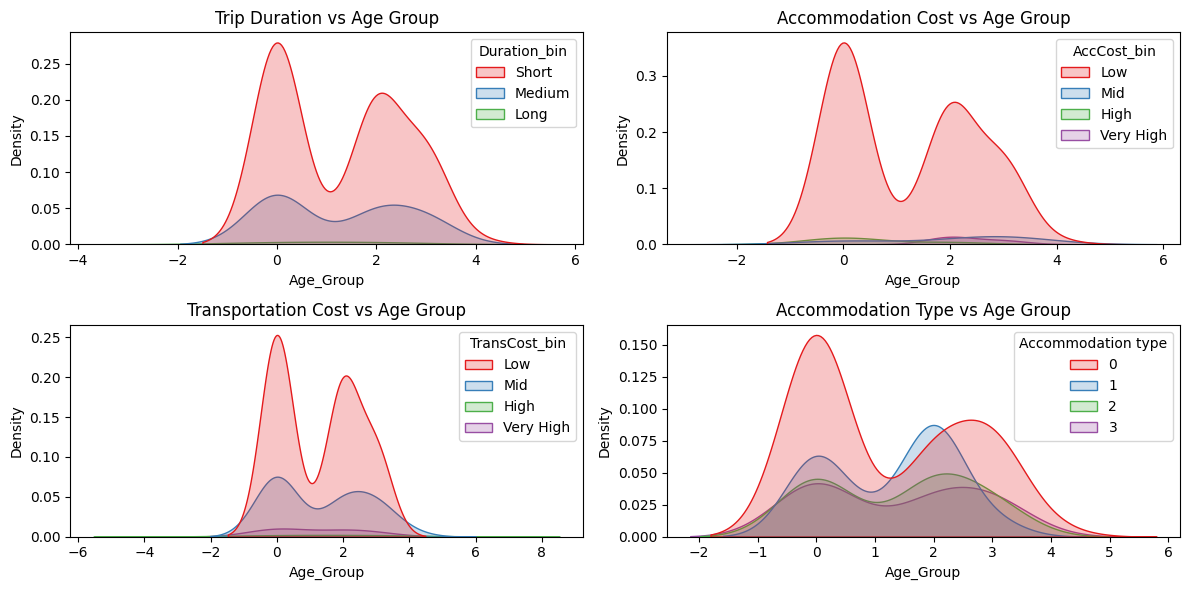

In [104]:
# Create binned versions for continuous variables
rare_ordinal_values["Duration_bin"] = pd.cut(
    rare_ordinal_values["Duration (days)"], bins=3, labels=["Short", "Medium", "Long"]
)
rare_ordinal_values["AccCost_bin"] = pd.cut(
    rare_ordinal_values["Accommodation cost"],
    bins=4,
    labels=["Low", "Mid", "High", "Very High"],
)
rare_ordinal_values["TransCost_bin"] = pd.cut(
    rare_ordinal_values["Transportation cost"],
    bins=4,
    labels=["Low", "Mid", "High", "Very High"],
)

# Now plot with binned hue values
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

sns.kdeplot(
    data=rare_ordinal_values,
    x="Age_Group",
    hue="Duration_bin",
    ax=axes[0, 0],
    fill=True,
    palette="Set1",
)
axes[0, 0].set_title("Trip Duration vs Age Group")

sns.kdeplot(
    data=rare_ordinal_values,
    x="Age_Group",
    hue="AccCost_bin",
    ax=axes[0, 1],
    fill=True,
    palette="Set1",
)
axes[0, 1].set_title("Accommodation Cost vs Age Group")

sns.kdeplot(
    data=rare_ordinal_values,
    x="Age_Group",
    hue="TransCost_bin",
    ax=axes[1, 0],
    fill=True,
    palette="Set1",
)
axes[1, 0].set_title("Transportation Cost vs Age Group")

sns.kdeplot(
    data=rare_ordinal_values,
    x="Age_Group",
    hue="Accommodation type",
    ax=axes[1, 1],
    fill=True,
    palette="Set1",
)
axes[1, 1].set_title("Accommodation Type vs Age Group")

plt.tight_layout()
plt.show()


📊 **1. Trip Duration vs Age Group**
Short trips dominate across all age groups, especially younger and mid-adults.

Medium trips are more evenly distributed, peaking in age groups 2–3.

Long trips are rare, possibly indicating that most travelers prefer quick getaways.

🧠 Insight: Marketing campaigns for weekend deals or short getaways may resonate best, particularly with younger travelers.

📊 **2. Accommodation Cost vs Age Group**
Low-cost accommodation peaks in younger age groups (0–1).

Mid and High costs appear more in age group 2–3.

Very high accommodation is nearly invisible, suggesting few luxury bookings.

🧠 Insight: Most travelers are cost-conscious, with a shift to mid-range spending as age increases. Tailored deals (e.g., “value for money” packages) for age group 2 could perform well.

📊 **3. Transportation Cost vs Age Group**
Similar pattern to accommodation: low-cost transport dominates across the board.

Mid to high costs gradually increase with age group.

Very high-cost options are barely chosen, possibly due to budget or route availability.

🧠 Insight: Budget airlines and mid-tier transport services are preferred. Bundling these with accommodation can be a value strategy for providers.

📊 **4. Accommodation Type vs Age Group**
Age group 0 has the widest spread of accommodation types, indicating flexibility.

Group 1–2 show tighter distributions (likely preferring Airbnb or hotels).

Group 4 is minimal, possibly due to low participation or strong preference for traditional lodging.

🧠 Insight: Young travelers value variety and may choose from hostels to Airbnb, while older groups stick with familiar choices. Customizable packages could benefit group 0.

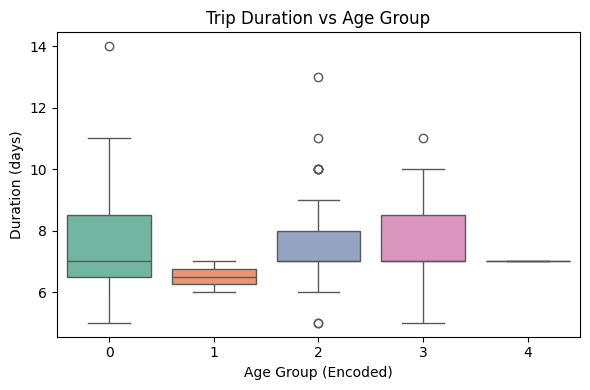

In [124]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Duration (days)",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Trip Duration vs Age Group")
plt.xlabel("Age Group (Encoded)")
plt.ylabel("Duration (days)")
plt.tight_layout()
plt.show()


✅ Hypothesis Addressed:
H2: Trip duration varies significantly with traveler age.

🔍 Insight:
Younger adults (encoded as 0) show wider variability and higher duration medians. Seniors travel less frequently or for shorter periods.

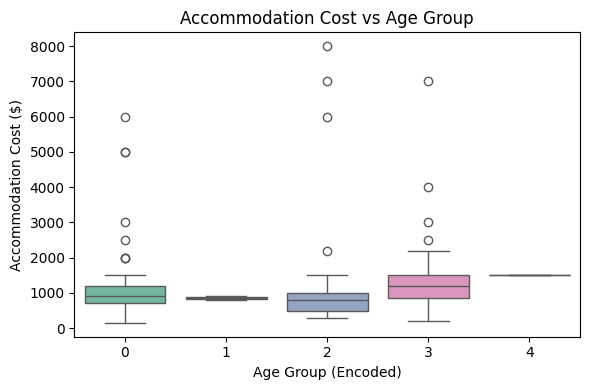

In [125]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Accommodation cost",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Accommodation Cost vs Age Group")
plt.xlabel("Age Group (Encoded)")
plt.ylabel("Accommodation Cost ($)")
plt.tight_layout()
plt.show()


✅ Hypothesis Addressed:
H4: Age correlates with accommodation cost.

🔍 Insight:
Costs are more varied among mid to older adults. Youth and young adults tend to spend less with fewer outliers.

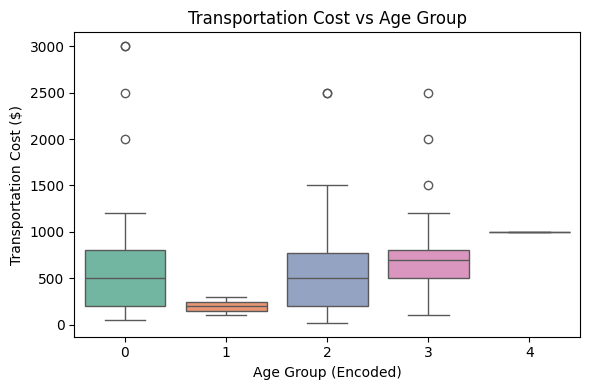

In [127]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Transportation cost",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Transportation Cost vs Age Group")
plt.xlabel("Age Group (Encoded)")
plt.ylabel("Transportation Cost ($)")
plt.tight_layout()
plt.show()


✅ Hypothesis Addressed:
H7: Transportation cost is influenced by age group (proxy for trip preference, destination type, etc.)

🔍 Insight:
Younger groups show wide variability (perhaps group travel or long-haul flights), while older groups appear more consistent.

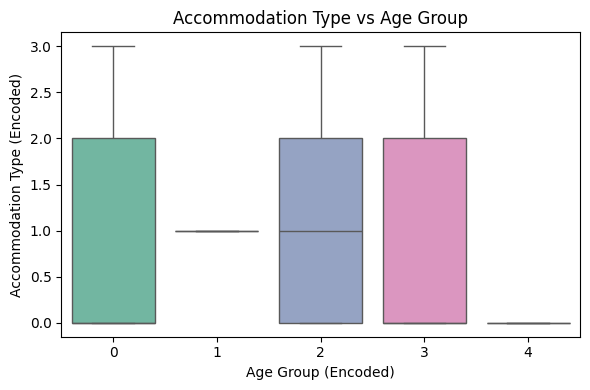

In [128]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Accommodation type",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Accommodation Type vs Age Group")
plt.xlabel("Age Group (Encoded)")
plt.ylabel("Accommodation Type (Encoded)")
plt.tight_layout()
plt.show()

✅ Hypothesis Addressed:
H6: Age influences accommodation type preference.

🔍 Insight:
Youth and young adults tend to prefer hostels and Airbnb (encoded as 1–2).

Mid to older age groups lean toward hotels or more expensive options.

---

We will look at violin plots (that combine boxplot structure with KDE, making them ideal for spotting multi-modal distributions and understanding spread)

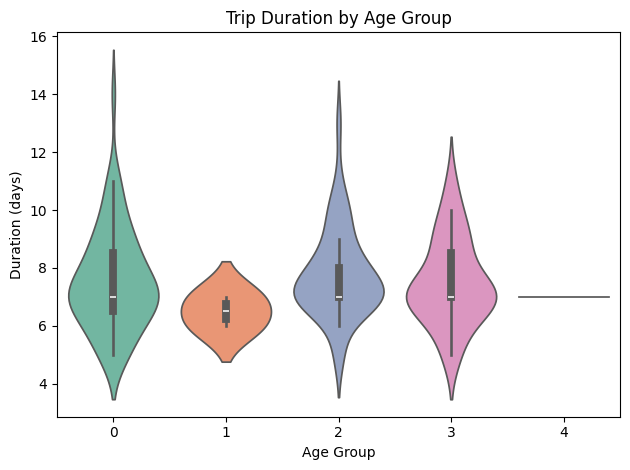

In [129]:
sns.violinplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Duration (days)",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Trip Duration by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Duration (days)")
plt.tight_layout()
plt.show()


**Insight:**

Younger adults (group 0 and 2) show wider distribution in trip duration, with occasional longer trips.

Older travelers (group 4) tend to stick to a consistent trip length with little variation.

Youth (group 2) appears to take both very short and long trips—indicating diverse motivations (e.g., gap years vs. weekend getaways).

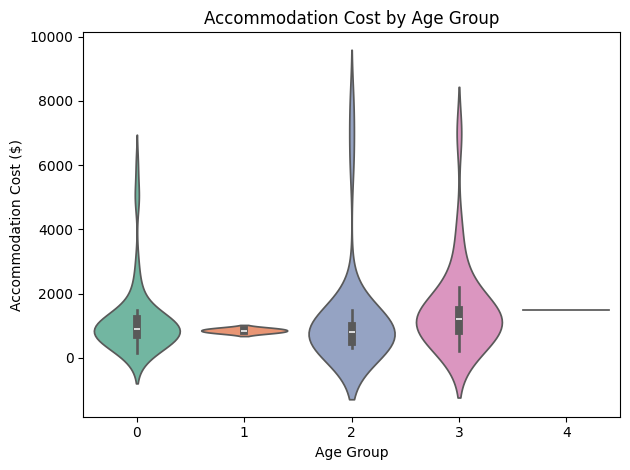

In [130]:
sns.violinplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Accommodation cost",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Accommodation Cost by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Accommodation Cost ($)")
plt.tight_layout()
plt.show()


**Insight:**

Accommodation spending is most varied among mature adults and mid-aged travelers (groups 2–3).

Younger adults (0) show long tails—some spend exceptionally, suggesting a mix of backpackers and luxury travelers.

Group 4 again stays within a tight range, possibly reflecting budget-conscious behavior or fixed pensions.

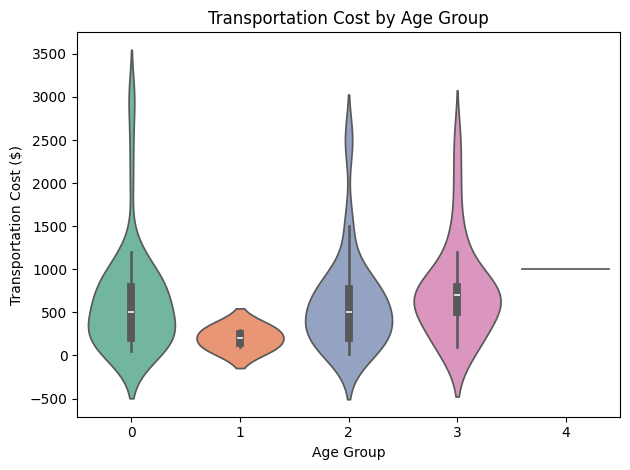

In [131]:
sns.violinplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Transportation cost",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Transportation Cost by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Transportation Cost ($)")
plt.tight_layout()
plt.show()


**Insight:**

Youth and young adults (groups 0–2) have broader variability, suggesting flexible travel modes (from budget airlines to premium).

Group 4 once again is most consistent—showing older age groups opt for reliable, mid-range travel.

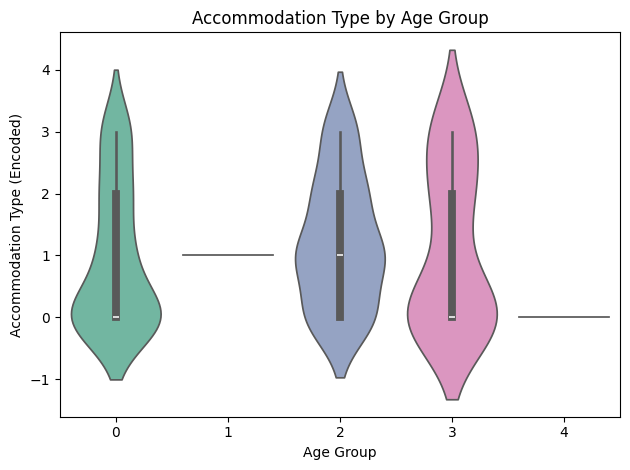

In [132]:
sns.violinplot(
    data=rare_ordinal_values,
    x="Age_Group",
    y="Accommodation type",
    hue="Age_Group",
    palette="Set2",
    legend=False,
)
plt.title("Accommodation Type by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Accommodation Type (Encoded)")
plt.tight_layout()
plt.show()


**Insight:**

Younger travelers tend to use a broader range of accommodation types (from hostels to Airbnb).

Older travelers largely stick with hotels or rare types—less flexibility.

Age groups 1 and 4 show the tightest clustering—indicating highly predictable accommodation choices.

---

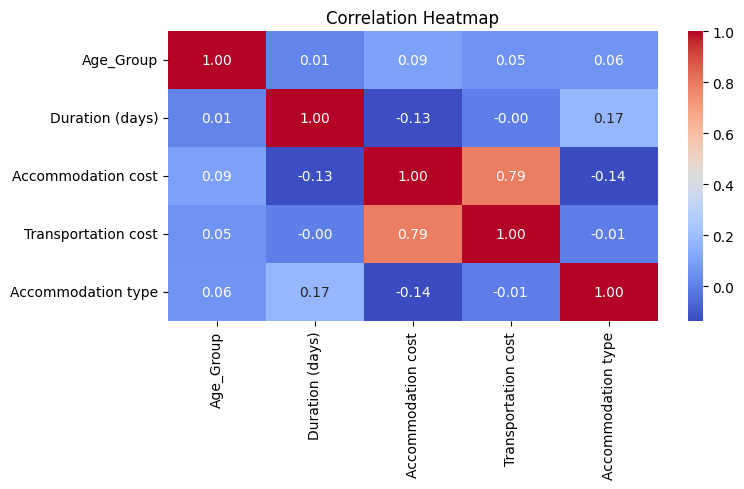

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric/encoded columns
corr_data = rare_ordinal_values[
    [
        "Age_Group",
        "Duration (days)",
        "Accommodation cost",
        "Transportation cost",
        "Accommodation type",
    ]
]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()
